In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
from helper import *
from load_dataframes import load_all
from plates import plates,timestep
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
import seaborn as sns
import matplotlib.pyplot as plt
logging.getLogger().setLevel(logging.WARNING)




c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [14]:
df,final_data = load_all(plates)

C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:111: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:112: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:113: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning:

All-NaN slice encountered



In [15]:
def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)

    # Calculate the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)
calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume', window=5)
calculate_derivative(final_data,f'tot_volume',f'derivative_tot_biovolume', window=5)

Vmax = 3e-9*25 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
carbon_ratio_spore = 0.9
dry_wet_ratio_spore = 0.9
density_spore = 0.9e-6
respiration_ratio = 0.5
final_data['P_rate'] =final_data['tot_surface_area_study']*Vmax
final_data['C_rate'] = final_data['derivative_biovolume']*density*dry_wet_ratio*carbon_ratio/respiration_ratio
final_data['totC_hypha'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio
final_data['tot_volume'] = final_data['spore_volume']+final_data['tot_biovolume_study']
final_data['totC_spore'] = final_data['spore_volume']*density_spore*dry_wet_ratio_spore*carbon_ratio_spore
final_data['totC_tot'] = final_data['totC_hypha'] + final_data['totC_spore']

final_data = final_data.reset_index(drop=True)

In [16]:
df['FungalSide'] = df['FungalSide'].fillna("100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")

df['treatment'] = df['treatment'].replace("1P100N100C","1P/100N/100C")
df['fungus'] = df['fungus'].replace("A5sp3","A5")


In [17]:
df['category_combination'] = df[['treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)
df['size_point'] = 20
marker_symbols = {
    "C2": 'circle',
    "A5": 'square',
    "Agg": 'diamond',
    "Clarum": 'cross',
    "C3": 'star',
    
    
    # Add more mappings as needed
}
df['full_category_combination'] = df[['fungus','treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# Map the strain to the marker symbol in the DataFrame
df['marker'] = df['fungus'].map(marker_symbols)


In [12]:
df[df['plate_id']=="471_20230821"]

,plate_id,start_x,speed,density_SA,density_BV,density_L,radius,radius_SA,strain,fungalC,...,Analysis priority,Running,Suitable for spores,real_root,date_fungus,age,category_combination,size_point,full_category_combination,marker
66,471_20230821,20230821,263.940338,0.026098,0.000041,1.366145,3.182569,3.043605,'C2','000P100N',...,NaN,NaN,NaN,Carrot Vasilis,2023-04-26,35,1P/100N/100C_0P/100N/100C_Carrot Vasilis,20,C2_1P/100N/100C_0P/100N/100C_Carrot Vasilis,circle


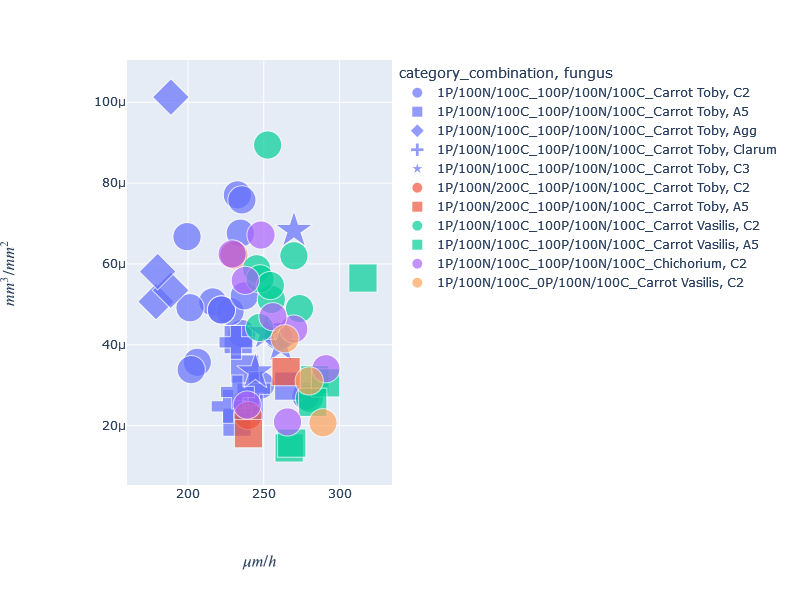

In [18]:
import plotly.express as px
fig = px.scatter(df, x='speed', y='density_BV', color='category_combination',
                 hover_data=['plate_id',"fungus"], size='size_point', symbol='fungus', symbol_map=marker_symbols)
fig.update_layout(height=600)  # You can change these values as per your preference
# Show the plot
fig.update_xaxes(title='wave speed ($\mu m/h$)',title_font=dict(size=100))
fig.update_yaxes(title='fungal BV density ($mm^3/mm^2$)',title_font=dict(size=100))

fig.show()

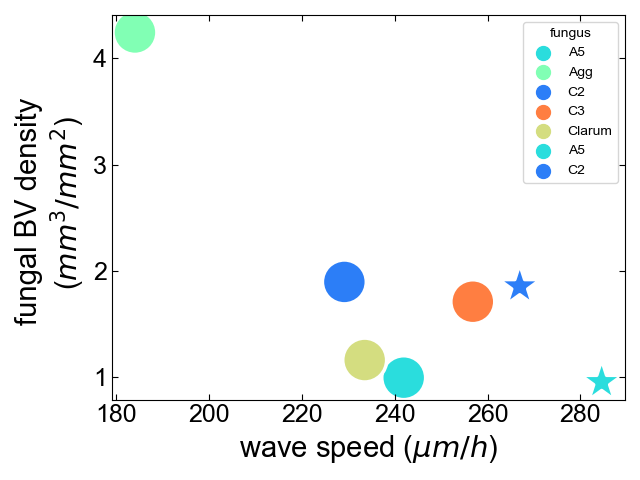

In [7]:
n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))
summary = df.groupby(['fungus','real_root','FungalSide','treatment'],as_index=False)[['speed','density_L']].mean()

fig,ax = plt.subplots()
# select = summary[summary['fungus'].isin(['A5','C2'])]
select = summary[summary['fungus'].isin(['C2','A5','Agg','Clarum'])]
select = summary[summary['fungus'].isin(['C2','A5','Agg','Clarum','C3'])]

select = select[select['real_root']!="Chichorium"]
select= select[select['FungalSide']=="100P/100N/100C"]
select= select[select['treatment']=="1P/100N/100C"]
cat = select[select['real_root']=="Carrot Toby"]
sns.scatterplot(cat, x='speed', y='density_L',hue="fungus",palette=strain_to_color,ax=ax,s = 1000)
cat = select[select['real_root']=="Carrot Vasilis"]
sns.scatterplot(cat, x='speed', y='density_L',hue="fungus",palette=strain_to_color,marker = "*",ax=ax,s = 1000)
# fig.update_layout(height=600)  # You can change these values as per your preference
# # Show the plot
# fig.update_xaxes(title='wave speed ($\mu m/h$)',title_font=dict(size=100))
# fig.update_yaxes(title='fungal BV density ($mm^3/mm^2$)',title_font=dict(size=100))
ax.set_xlabel('wave speed ($\mu m/h$)')
ax.set_ylabel('fungal BV density \n ($mm^3/mm^2$)')
plt.tight_layout()


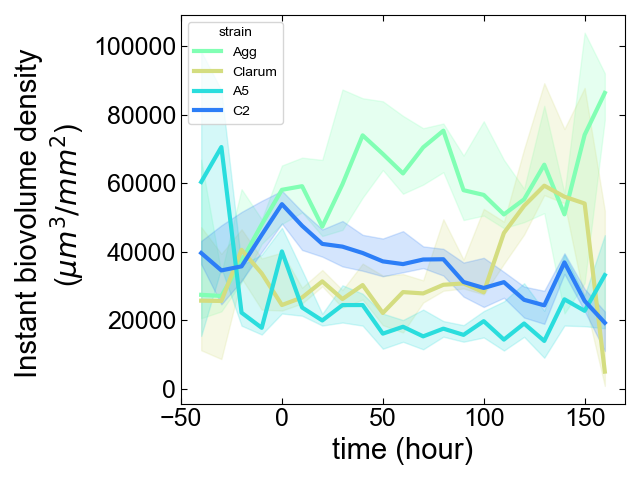

In [8]:
calculate_derivative(final_data,f'tot_surface_area_study',f'derivative_SA', window=5)
calculate_derivative(final_data,f'area_sep_comp',f'derivative_area', window=5)
final_data['instant_SA_dens'] = final_data['derivative_SA']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_BV', window=5)
final_data['instant_BV_dens'] = final_data['derivative_BV']/final_data['derivative_area']
calculate_derivative(final_data,f'tot_length_study',f'derivative_L', window=5)
final_data['instant_L_dens'] = final_data['derivative_L']/final_data['derivative_area']
final_data['instant_radius'] = final_data['instant_BV_dens']/final_data['instant_SA_dens']*2
fig, ax = plt.subplots()

select = final_data
# select= final_data[final_data['real_root']=="Carrot Toby"]
select= select[select['real_root']=="Carrot Toby"]
# select= select[select['strain']=="C2"]
select= select[select['time_hour_binned']<=160]
select= select[select['instant_SA_dens']<=8e4]
select= select[select['instant_SA_dens']>0]
select= select[select['time_hour_binned']>=-40]
select = select[select['strain'].isin(['C2','A5','Agg','Clarum'])]




# sns.scatterplot(data=select,x='time_since_begin_h_shifted',y='tot_surface_area_study',size = 5,alpha = 0.3,legend=False,color="grey")

sns.lineplot(data=select,x='time_hour_binned',y='instant_BV_dens',hue = "strain",estimator = "median",palette=strain_to_color)
ax.set_ylabel('Instant biovolume density \n ($\mu m^3/mm^2$)')
ax.set_xlabel('time (hour)')
# ax.set_ylim(0,60000)
plt.tight_layout()


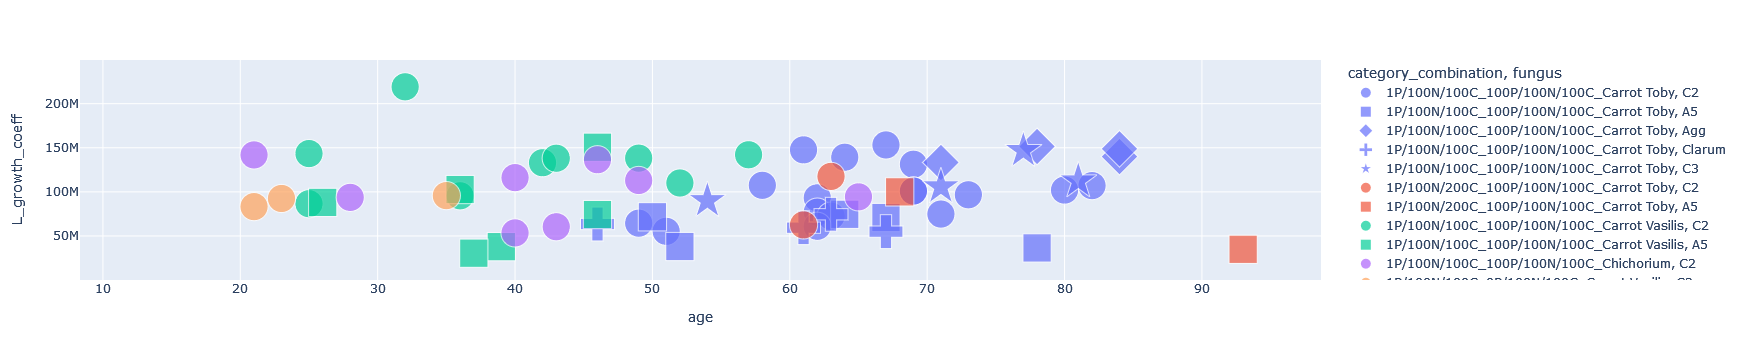

In [8]:
import plotly.express as px
fig = px.scatter(df, x='age', y='L_growth_coeff', color='category_combination',
                 hover_data=['plate_id',"fungus"], size='size_point', symbol='fungus', symbol_map=marker_symbols)
fig.update_layout(height=600)  # You can change these values as per your preference
# Show the plot
fig.show()

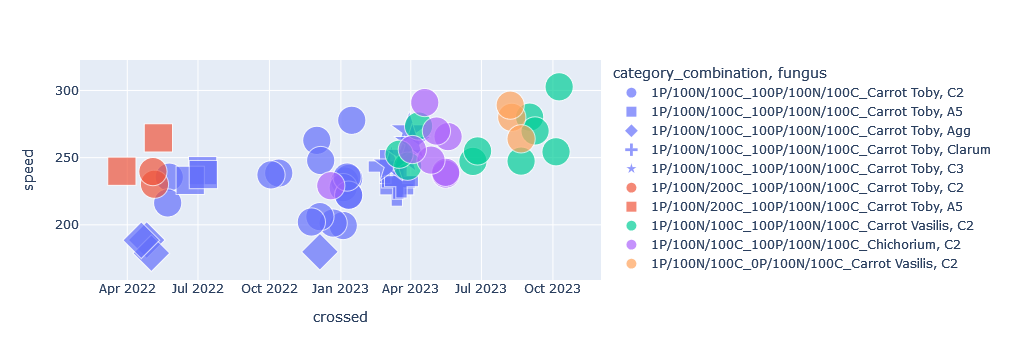

In [7]:
import plotly.express as px
fig = px.scatter(df, x='crossed', y='speed', color='category_combination',
                 hover_data=['plate_id',"fungus"], size='size_point', symbol='fungus', symbol_map=marker_symbols)
fig.update_layout(height=600)  # You can change these values as per your preference
# Show the plot
fig.show()

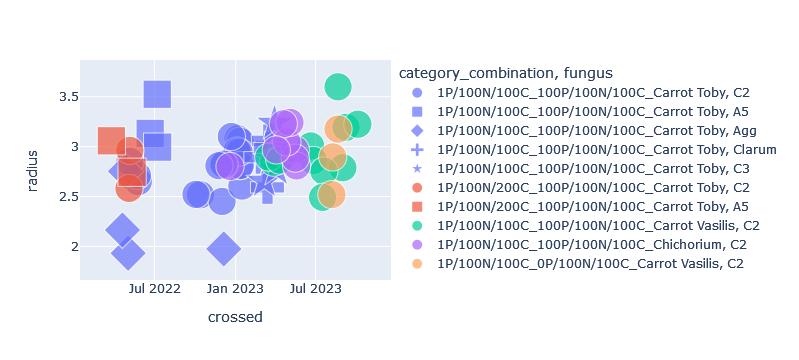

In [30]:
import plotly.express as px
fig = px.scatter(df, x='crossed', y='radius', color='category_combination',
                 hover_data=['plate_id',"fungus"], size='size_point', symbol='fungus', symbol_map=marker_symbols)
fig.update_layout(height=600)  # You can change these values as per your preference
# Show the plot
fig.show()

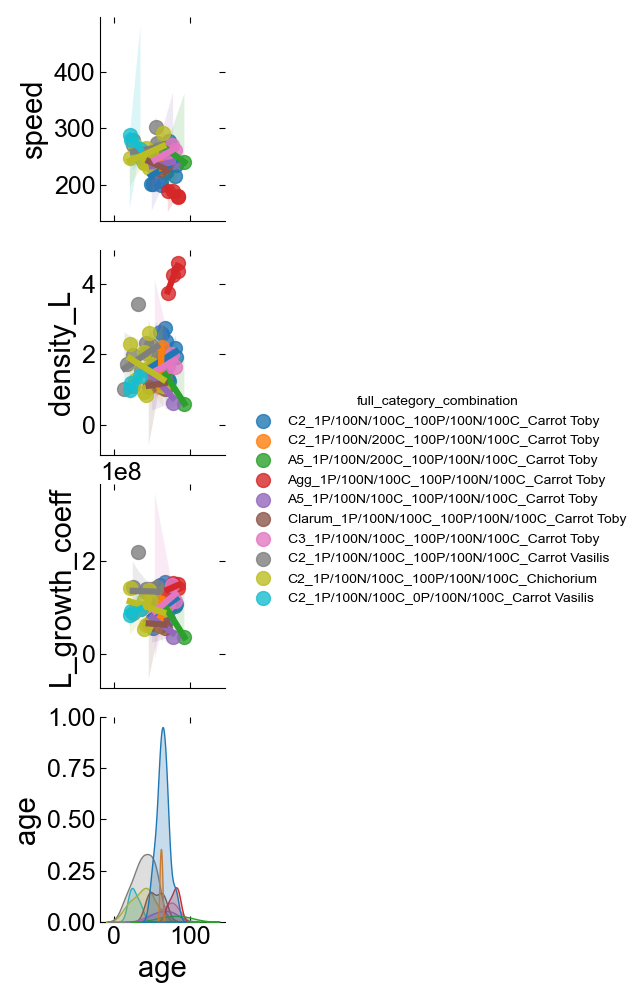

In [39]:
columnsy = ['speed','density_L','L_growth_coeff','age']
columnsx = ['age']

sns.pairplot(df,hue="full_category_combination",x_vars=columnsx,y_vars=columnsy,kind="reg")

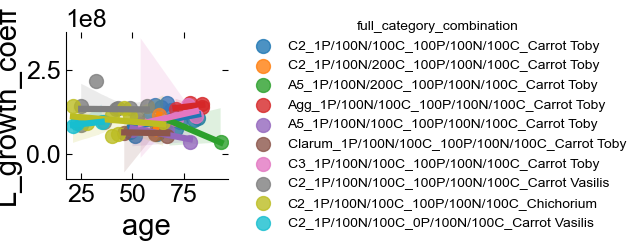

In [10]:
columnsy = ['L_growth_coeff']
columnsx = ['age']

sns.pairplot(df,hue="full_category_combination",x_vars=columnsx,y_vars=columnsy,kind="reg")

In [54]:
select['treatment'].unique()

array(['1P/100N/100C', '1P/100N/200C'], dtype=object)

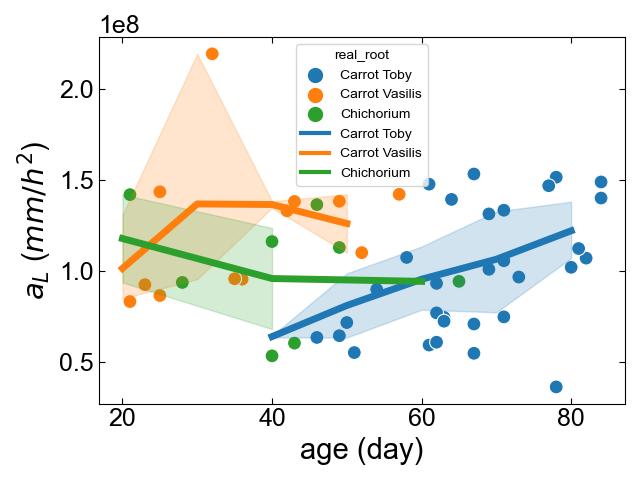

In [59]:
fig,ax = plt.subplots()
df['age_round']=df['age'].astype(int)//10*10
select = df
# select = df[df['real_root']=="Carrot Toby"]
# select = select[select['fungus']=="C2"]
select = select[select['treatment']=='1P/100N/100C']

# select = select[select['L_growth_coeff']>=0.4e8]
# select = select[select['L_growth_coeff']<=2e8]
data = select.groupby('age_round')['L_growth_coeff'].mean()
sns.scatterplot(select,x='age',y="L_growth_coeff",hue = "real_root")

sns.lineplot(data=select, x='age_round', y=select['L_growth_coeff'], hue='real_root', ax=ax,estimator='mean', lw=5, ls="-")
ax.set_xlabel("age (day)")
ax.set_ylabel( '$a_L$ ($mm/h^2$)')
plt.tight_layout()

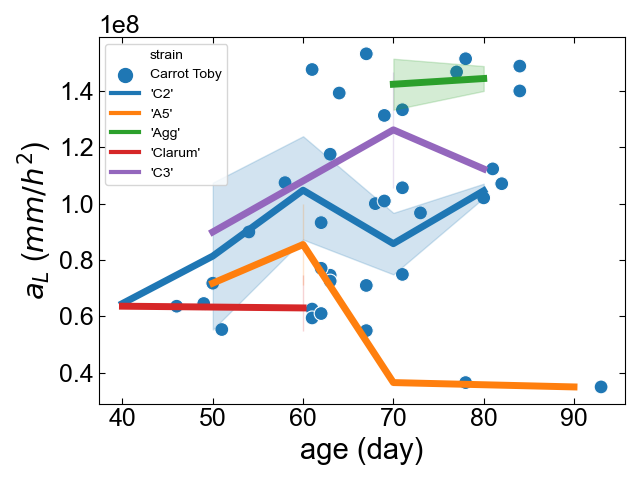

In [58]:
fig,ax = plt.subplots()
df['age_round']=df['age'].astype(int)//10*10
select = df
select = df[df['real_root']=="Carrot Toby"]
# select = select[select['fungus']=="C2"]
# select = select[select['treatment']=='1P/100N/100C']

# select = select[select['L_growth_coeff']>=0.4e8]
# select = select[select['L_growth_coeff']<=2e8]
data = select.groupby('age_round')['L_growth_coeff'].mean()
sns.scatterplot(select,x='age',y="L_growth_coeff",hue = "real_root")

sns.lineplot(data=select, x='age_round', y=select['L_growth_coeff'], hue='strain', ax=ax,estimator='mean', lw=5, ls="-")
ax.set_xlabel("age (day)")
ax.set_ylabel( '$a_L$ ($mm/h^2$)')
plt.tight_layout()

Text(0, 0.5, 'growth coef (D)')

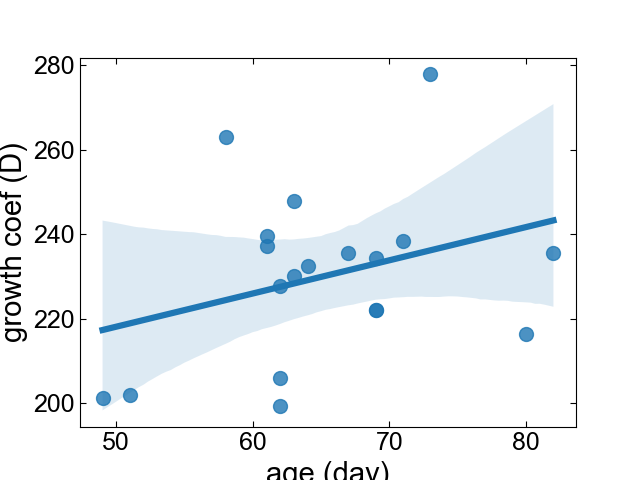

In [39]:
fig,ax = plt.subplots()
select = df[df['real_root']=="Carrot Toby"]
select = select[select['fungus']=="C2"]
select = select[select['L_growth_coeff']>=0.4e8]
select = select[select['L_growth_coeff']<=2e8]


sns.regplot(select,x='age',y="speed")
ax.set_xlabel("age (day)")
ax.set_ylabel("growth coef (D)")

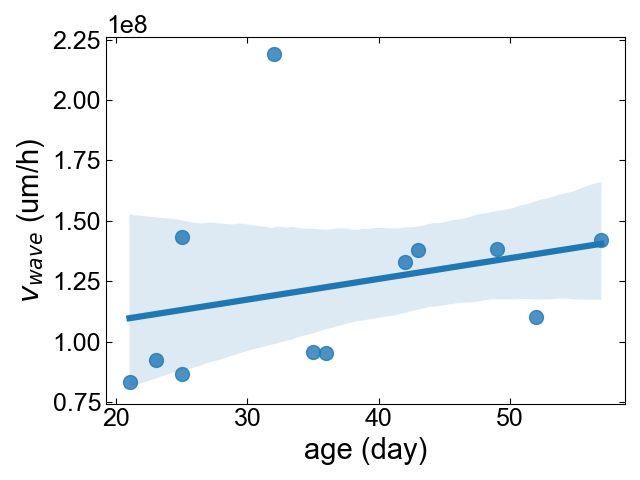

In [40]:
fig,ax = plt.subplots()
select = df[df['real_root']=='Carrot Vasilis']
select = select[select['strain']=="'C2'"]

# select= merged_df
sns.regplot(select,x='age',y='L_growth_coeff')
# for index,row in select.iterrows():
#     ax.text(row['age'],row['speed'],row['unique_id'])
ax.set_xlabel('age (day)')
ax.set_ylabel('$v_{wave}$ (um/h)')
plt.tight_layout()

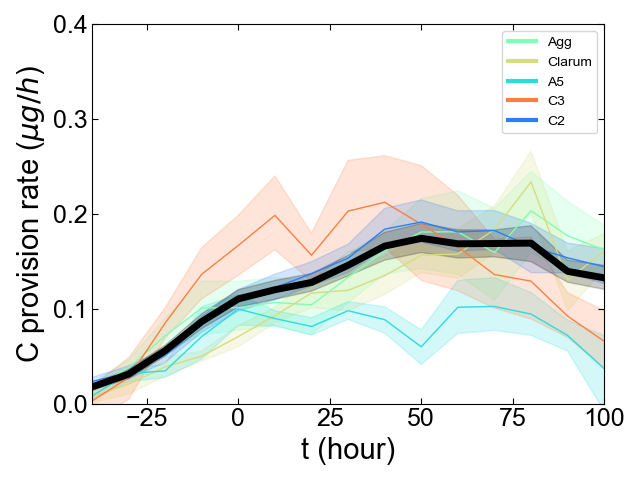

In [7]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = final_data[final_data['real_root']=="Carrot Toby"]

sns.lineplot(data=select, x='time_hour_binned', y=select['C_rate'], hue='strain',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['C_rate'], ax=ax, color = 'black', estimator='mean', lw=5, ls="-")

# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
ax.set_ylim(0,0.4)
ax.set_ylabel('C provision rate ($\mu g/h$)')
ax.set_xlabel('t (hour)')
ax.set_xlim(-40,100)
plt.tight_layout()
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


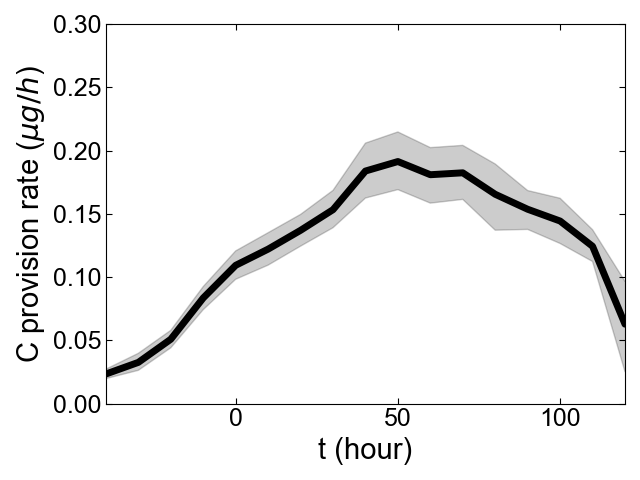

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sample data
# I don't have access to your 'final_data', so I'm just using this structure for demonstration purposes.

# fig,ax setup
fig, ax = plt.subplots()

# Filter your data
tmax = 150
select = final_data[final_data['time_since_begin_h_shifted'] <= tmax]
select = final_data[final_data['real_root'] == "Carrot Toby"]
select = select[select['strain'] == "C2"]

# Plot each individual trajectory
# for unique_id in select['unique_id'].unique():
#     individual_data = select[select['unique_id'] == unique_id]
#     ax.plot(individual_data['time_since_begin_h_shifted'], individual_data['C_rate'], alpha=0.5,color="grey") # You can adjust alpha for visibility

# Plot the mean trajectory
sns.lineplot(data=select, x='time_hour_binned', y='C_rate', ax=ax, color='black', estimator='mean', lw=5, ls="-")

# Adjusting the plot
# ax.legend().remove()  # If you don't want to show the legend
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
ax.set_ylim(0, 0.3)
ax.set_ylabel('C provision rate ($\mu g/h$)')
ax.set_xlim(-40, 120)

plt.tight_layout()

# Save the figure
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')
plt.show()


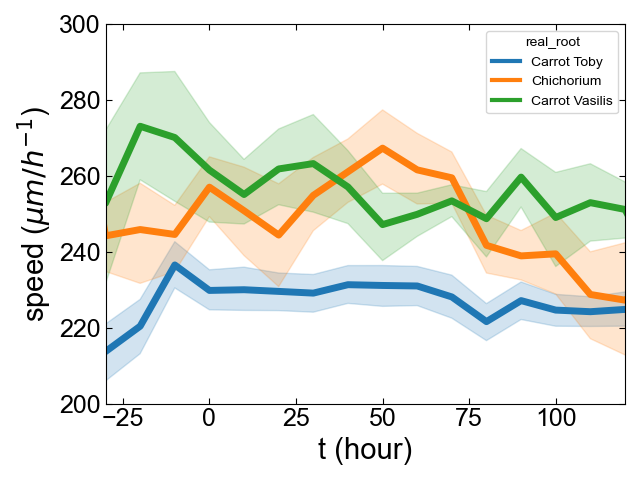

In [9]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
# select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = final_data[final_data['strain'] == "C2"]

# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['hull_speed'], hue='real_root', ax=ax, estimator='mean', lw=5, ls="-")
# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('speed ($\mu m/h^{-1}$)')
ax.set_ylim(200,300)
ax.set_xlim(-30, 120)
plt.tight_layout()
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


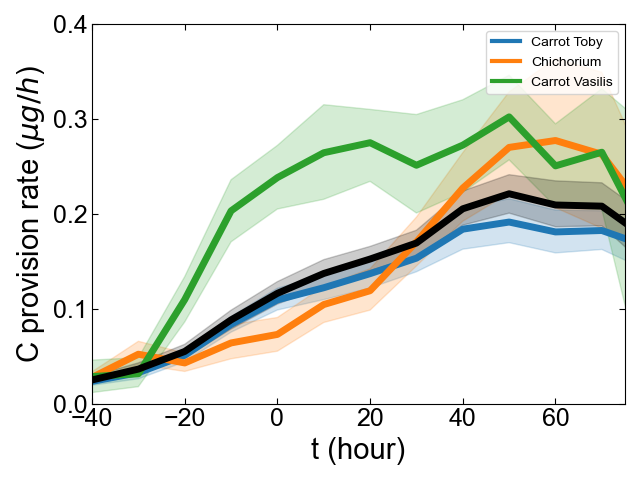

In [13]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = final_data[final_data['strain']=="C2"]

# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['C_rate'], hue='real_root', ax=ax, estimator='mean', lw=5, ls="-")
sns.lineplot(data=select, x='time_hour_binned', y=select['C_rate'], ax=ax, color = 'black', estimator='mean', lw=5, ls="-")

# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
ax.set_ylim(0,0.4)
ax.set_ylabel('C provision rate ($\mu g/h$)')
ax.set_xlabel('t (hour)')
ax.set_xlim(-40, 75)
plt.tight_layout()
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


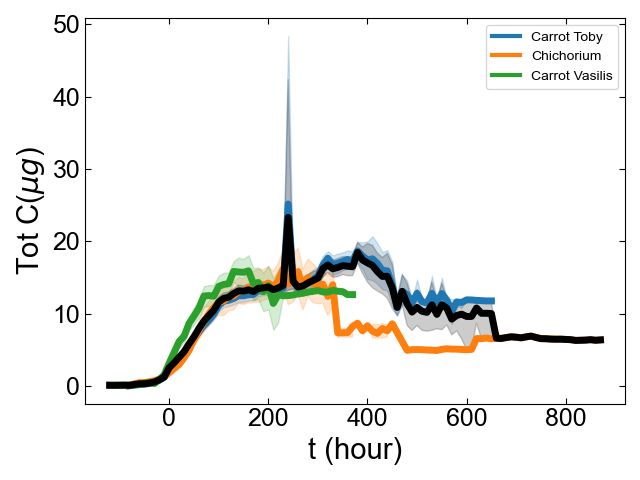

In [16]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = final_data[final_data['strain']=="C2"]

# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['totC_hypha'], hue='real_root', ax=ax, estimator='mean', lw=5, ls="-")
sns.lineplot(data=select, x='time_hour_binned', y=select['totC_hypha'], ax=ax, color = 'black', estimator='mean', lw=5, ls="-")

# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
# ax.set_ylim(0,0.4)
ax.set_ylabel('Tot C($\mu g$)')
ax.set_xlabel('t (hour)')
# ax.set_xlim(-40, 75)
plt.tight_layout()
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


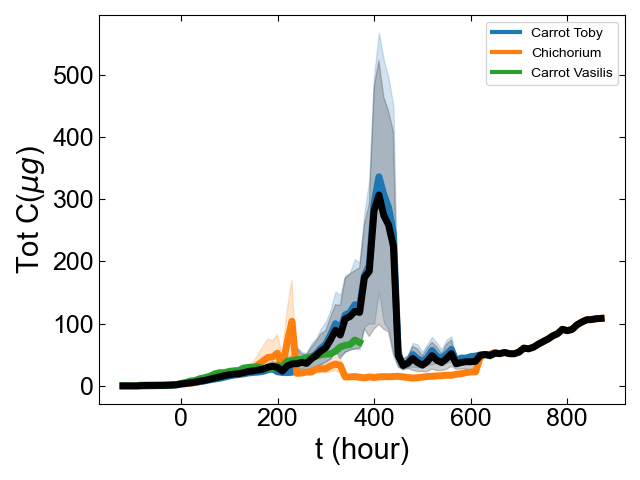

In [21]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = final_data[final_data['strain']=="C2"]

# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['totC_tot'], hue='real_root', ax=ax, estimator='mean', lw=5, ls="-")
sns.lineplot(data=select, x='time_hour_binned', y=select['totC_tot'], ax=ax, color = 'black', estimator='mean', lw=5, ls="-")

# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
# ax.set_ylim(0,0.4)
ax.set_ylabel('Tot C($\mu g$)')
ax.set_xlabel('t (hour)')
# ax.set_xlim(-40, 75)
plt.tight_layout()
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


In [ ]:

# Assuming select DataFrame and strain_to_color dictionary already exist
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = select[select['late_start']==False]

# Sort the data by strain and tot_surface_area_study
select = select.sort_values(by=['strain', 'time_since_begin_h_shifted'])

# Calculate moving average for each strain based on tot_surface_area_study ordering
window_size = 30
select['totC_ma'] = select.groupby('strain')['totC'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).mean())

# Plotting
fig, ax = plt.subplots(figsize=(5,8))
sns.scatterplot(data=select, x='time_since_begin_h_shifted', y='totC', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
sns.lineplot(data=select, x='time_since_begin_h_shifted', y='totC_ma', hue='strain', ax=ax, palette=strain_to_color, legend=False)  # suppress legend for lineplot
# ax.set_ylim(0,2e6)


In [ ]:

# Assuming select DataFrame and strain_to_color dictionary already exist
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = select[select['late_start']==False]

# Sort the data by strain and tot_surface_area_study
select = select.sort_values(by=['strain', 'time_since_begin_h_shifted'])

# Calculate moving average for each strain based on tot_surface_area_study ordering
window_size = 30
select['C_rate_ma'] = select.groupby('strain')['C_rate'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).mean())

# Plotting
fig, ax = plt.subplots(figsize=(5,8))
sns.scatterplot(data=select, x='time_since_begin_h_shifted', y='C_rate', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
sns.lineplot(data=select, x='time_since_begin_h_shifted', y='C_rate_ma', hue='strain', ax=ax, palette=strain_to_color, legend=False)  # suppress legend for lineplot
ax.set_ylim(0,0.6)
ax.set_ylabel('C provision rate ($\mu g/h$)')
ax.set_xlabel('t (hour)')
ax.set_xlim(-20,130)
